In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive"

import os

%cd "/content"

Mounted at /content/drive
 BraTs2021_20.h5			     fox
'Colab Notebooks'			     liverresnet50.h5.pth
 dataset				     pothole_resnet_50_model.h5
 datasets				     pothole_vgg_model.h5
 diabetic_retinopathy_resnet_50_model.h5     yolov3
 diabetic_retinopathy_resnet_50v2_model.h5   yolov5
/content


In [2]:
!ls "/content/drive/MyDrive/datasets"

'Blood Cell Dataset.zip'   coco128		   detection_data
'brain segmentation.zip'   coco2017labels.zip	   Diabetic_Dataset.zip
 braintumor_dataset.zip    Dataset_FireSmoke.zip   livertumordataset1.zip
 coco			   dataset.zip		   liver_tumor_dataset.zip


In [3]:
base_dataset_folder = "/content/drive/MyDrive/datasets/"
zip_file = "liver_tumor_dataset.zip"
dataset_zip = base_dataset_folder+zip_file

In [4]:
!mkdir dataset
!unzip $dataset_zip -d dataset

Archive:  /content/drive/MyDrive/datasets/liver_tumor_dataset.zip
   creating: dataset/liver_tumor_dataset/
  inflating: dataset/__MACOSX/._liver_tumor_dataset  
  inflating: dataset/liver_tumor_dataset/.DS_Store  
  inflating: dataset/__MACOSX/liver_tumor_dataset/._.DS_Store  
   creating: dataset/liver_tumor_dataset/Tumor/
  inflating: dataset/__MACOSX/liver_tumor_dataset/._Tumor  
   creating: dataset/liver_tumor_dataset/Normal/
  inflating: dataset/__MACOSX/liver_tumor_dataset/._Normal  
  inflating: dataset/liver_tumor_dataset/Tumor/images (2).jpeg  
  inflating: dataset/__MACOSX/liver_tumor_dataset/Tumor/._images (2).jpeg  
  inflating: dataset/liver_tumor_dataset/Tumor/download.jpeg  
  inflating: dataset/__MACOSX/liver_tumor_dataset/Tumor/._download.jpeg  
  inflating: dataset/liver_tumor_dataset/Tumor/000131 (2).png  
  inflating: dataset/__MACOSX/liver_tumor_dataset/Tumor/._000131 (2).png  
  inflating: dataset/liver_tumor_dataset/Tumor/Screenshot 2022-12-28 at 2.42.30 PM.png

## Liver tumour Detection

### 1) Import Needed Modules

In [5]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras
from numba import cuda

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


### 2) Data loading

In [6]:
# main_folder = "./rice_leaf_diseases/"
main_folder = "/content/dataset/liver_tumor_dataset"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))



['Normal', 'Tumor'] 2


In [7]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (224,224,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg") or (file_ext.lower() == "png"):
              try:
                    imgname = main_folder+"/"+category+"/"+image_name
                    imgname = imgname.replace("//", "/")
                    img = cv2.imread(imgname)
                    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    img_rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
                    img_rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    img_flip_ver = cv2.flip(img, 0)
                    img_flip_hor = cv2.flip(img, 1)

                    img_array = Image.fromarray(img, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_180, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_270, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_ver, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_hor, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

              except:
                    print(imgname)
                    print(img)
                

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 Normal


100%|██████████| 38/38 [00:00<00:00, 98.02it/s] 


1 Tumor


100%|██████████| 80/80 [00:00<00:00, 100.76it/s]


Total Images Loaded: 812


In [8]:
images = np.array(images)
labels = np.array(labels)

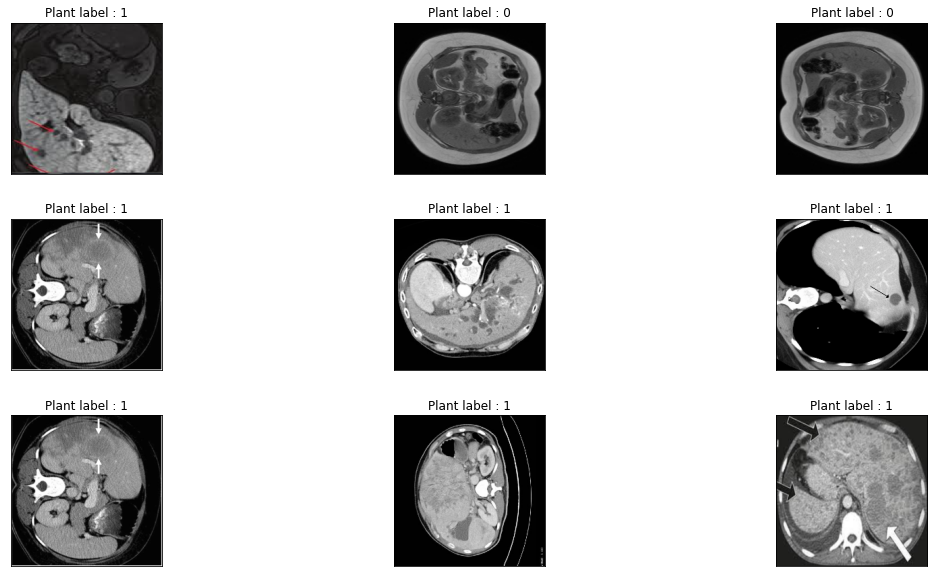

In [9]:
def display_random_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Plant label : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_random_images(images, labels)

In [10]:
np.random.seed(RANDOM_SEED)


n = np.arange(images.shape[0])
np.random.shuffle(n)

images = images[n]
labels = labels[n]

- Step 2 - Data normalization

In [11]:
images = images.astype(np.float32)
labels = labels.astype(np.int8)
images /= 255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (812, 224, 224, 3)


- Display few random images after normalization

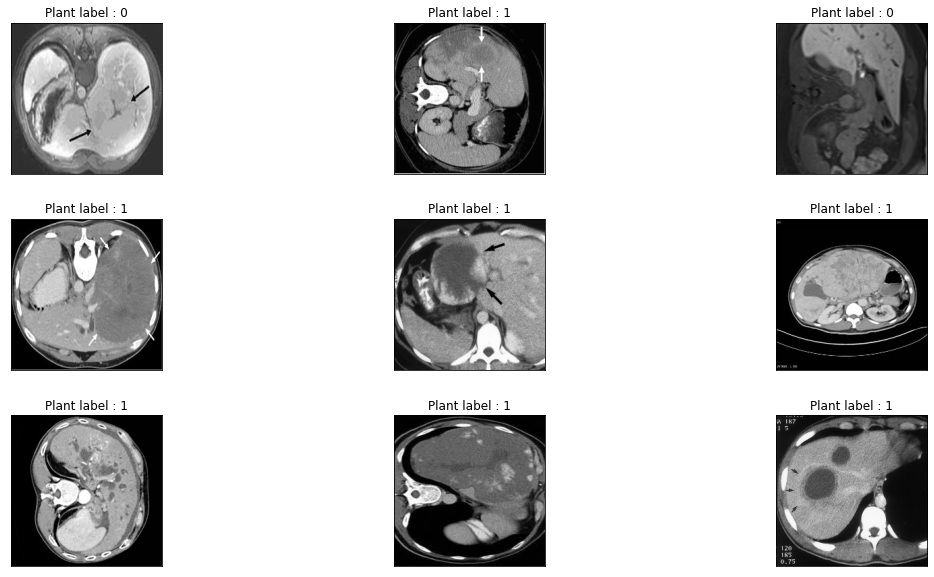

In [12]:
display_random_images(images, labels)

- Split dataset for training and testing

In [13]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = RANDOM_SEED)


print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (649, 224, 224, 3)
y_train shape =  (649,)

x_test shape =  (163, 224, 224, 3)
y_test shape =  (163,)


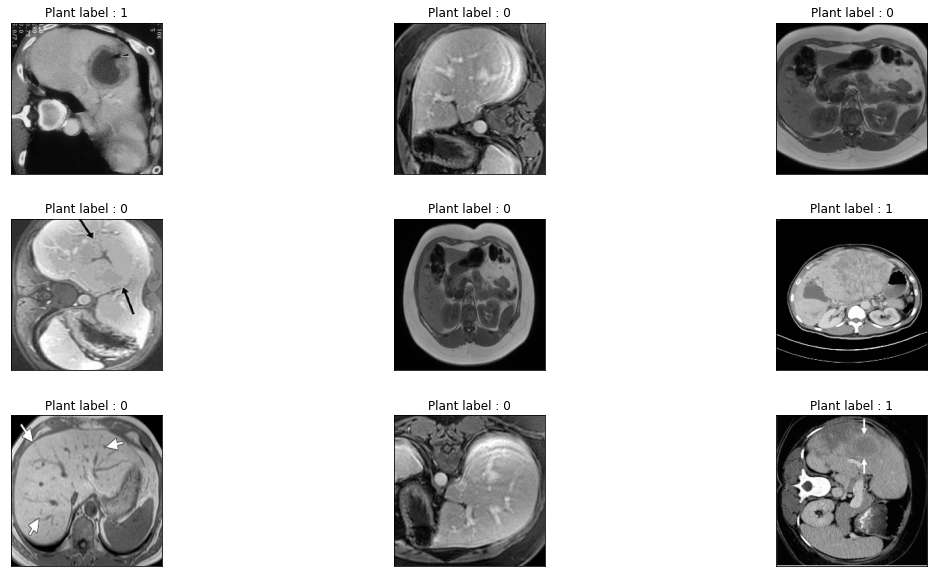

In [14]:
display_random_images(x_train, y_train)

In [15]:
EPOCHS = 10
BATCH_SIZE = 16


## VGG 19

In [16]:
vgg = VGG19(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 5s 0us/step


In [17]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [18]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)
vgg_model.summary()# view the structure of the model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [20]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=15, restore_best_weights=True)

In [21]:
# fit the model
vgg_history = vgg_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/10
10/10 [==============================] - 11s 234ms/step - loss: 1.0361 - accuracy: 0.6812 - val_loss: 0.3287 - val_accuracy: 0.8438
Epoch 2/10
10/10 [==============================] - 2s 194ms/step - loss: 0.5342 - accuracy: 0.7375 - val_loss: 0.2223 - val_accuracy: 0.9187
Epoch 3/10
10/10 [==============================] - 2s 194ms/step - loss: 0.4854 - accuracy: 0.8188 - val_loss: 0.1700 - val_accuracy: 0.9312
Epoch 4/10
10/10 [==============================] - 2s 189ms/step - loss: 0.3843 - accuracy: 0.8313 - val_loss: 0.3557 - val_accuracy: 0.8813
Epoch 5/10
10/10 [==============================] - 3s 195ms/step - loss: 0.1366 - accuracy: 0.9412 - val_loss: 0.1226 - val_accuracy: 0.9625
Epoch 6/10
10/10 [==============================] - 2s 189ms/step - loss: 0.0781 - accuracy: 0.9812 - val_loss: 0.1324 - val_accuracy: 0.9438
Epoch 7/10
10/10 [==============================] - 2s 195ms/step - loss: 0.0825 - accuracy: 0.9750 - val_loss: 0.1062 - val_accuracy: 0.9750
Epoch

In [22]:
tf.keras.backend.clear_session()
vgg_loss, vgg_acc = vgg_model.evaluate(x_test,y_test,batch_size=32)
print("VGG 19 Loss:", vgg_loss)
print("VGG 19 Accuracy:", vgg_acc*100, "%")

6/6 [==============================] - 4s 300ms/step - loss: 0.1132 - accuracy: 0.9571
VGG 19 Loss: 0.11318079382181168
VGG 19 Accuracy: 95.70552110671997 %


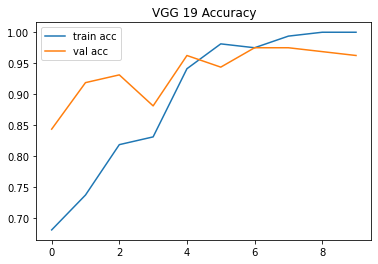

In [23]:
# accuracies
plt.plot(vgg_history.history['accuracy'], label='train acc')
plt.plot(vgg_history.history['val_accuracy'], label='val acc')
plt.title("VGG 19 Accuracy")
plt.legend()
plt.show()

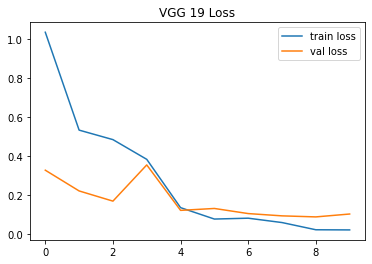

In [24]:
# loss
plt.plot(vgg_history.history['loss'], label='train loss')
plt.plot(vgg_history.history['val_loss'], label='val loss')
plt.title("VGG 19 Loss")
plt.legend()
plt.show()

In [25]:
#predict
y_pred = vgg_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))#get classification report

6/6 [==============================] - 1s 168ms/step
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        46
           1       0.98      0.96      0.97       117

    accuracy                           0.96       163
   macro avg       0.94      0.96      0.95       163
weighted avg       0.96      0.96      0.96       163



In [26]:
print(confusion_matrix(y_pred,y_test))#get confusion matrix

vgg_model.save("/content/drive/MyDrive/pothole_vgg_model.h5", save_format="h5")


[[ 44   2]
 [  5 112]]


# RESNET 50

In [27]:
resnet_50 = ResNet50(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 5s 0us/step


In [28]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50.layers:
    layer.trainable = False

In [29]:
x = Flatten()(resnet_50.output)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_model = Model(inputs=resnet_50.input, outputs=prediction)
resnet_50_model.summary()# view the structure of the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [30]:
resnet_50_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [31]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

In [32]:
# fit the model
resnet_50_history = resnet_50_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/10
40/40 [==============================] - 7s 93ms/step - loss: 1.9208 - accuracy: 0.7000 - val_loss: 0.2317 - val_accuracy: 0.8750
Epoch 2/10
40/40 [==============================] - 3s 63ms/step - loss: 0.3447 - accuracy: 0.8357 - val_loss: 0.2346 - val_accuracy: 0.8750
Epoch 3/10
40/40 [==============================] - 3s 65ms/step - loss: 0.3009 - accuracy: 0.8736 - val_loss: 0.2527 - val_accuracy: 0.9000
Epoch 4/10
40/40 [==============================] - 3s 66ms/step - loss: 0.2321 - accuracy: 0.8973 - val_loss: 0.1520 - val_accuracy: 0.9375
Epoch 5/10
40/40 [==============================] - 3s 64ms/step - loss: 0.2719 - accuracy: 0.9021 - val_loss: 0.2509 - val_accuracy: 0.9062
Epoch 6/10
40/40 [==============================] - 3s 63ms/step - loss: 0.2436 - accuracy: 0.9068 - val_loss: 0.2528 - val_accuracy: 0.9000
Epoch 7/10
40/40 [==============================] - 3s 64ms/step - loss: 0.1958 - accuracy: 0.9163 - val_loss: 0.2260 - val_accuracy: 0.9250
Epoch 8/10
40

In [33]:
resnet_50_loss,resnet_50_acc = resnet_50_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50 Loss:", resnet_50_loss)
print("Resnet_50 Accuracy:", resnet_50_acc*100, "%")

6/6 [==============================] - 2s 153ms/step - loss: 0.2116 - accuracy: 0.9387
Resnet_50 Loss: 0.21163177490234375
Resnet_50 Accuracy: 93.86503100395203 %


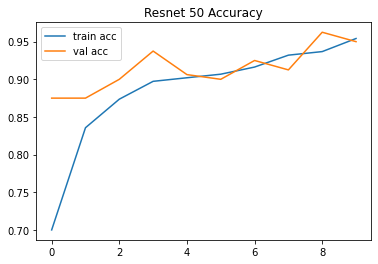

In [34]:
# accuracies
plt.plot(resnet_50_history.history['accuracy'], label='train acc')
plt.plot(resnet_50_history.history['val_accuracy'], label='val acc')
plt.title("Resnet 50 Accuracy")
plt.legend()
plt.show()

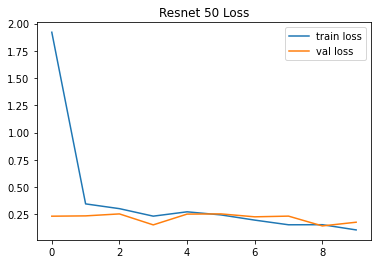

In [35]:
# loss
plt.plot(resnet_50_history.history['loss'], label='train loss')
plt.plot(resnet_50_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 Loss")
plt.legend()
plt.show()

In [36]:
#predict
y_pred=resnet_50_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

6/6 [==============================] - 1s 89ms/step
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        59
           1       0.91      1.00      0.95       104

    accuracy                           0.94       163
   macro avg       0.96      0.92      0.93       163
weighted avg       0.94      0.94      0.94       163



In [37]:
print(confusion_matrix(y_pred,y_test))#get confusion matrix

resnet_50_model.save("/content/drive/MyDrive/pothole_resnet_50_model.h5", save_format="h5")

[[ 49  10]
 [  0 104]]


## RESNET 50V2

In [38]:
resnet_50_v2 = ResNet50V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

94668760/94668760 [==============================] - 5s 0us/step


In [39]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50_v2.layers:
    layer.trainable = False

In [40]:
x = Flatten()(resnet_50_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_v2_model = Model(inputs=resnet_50_v2.input, outputs=prediction)
# view the structure of the model
resnet_50_v2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [41]:
resnet_50_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

In [42]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

In [43]:
# fit the model
resnet_50_v2_history = resnet_50_v2_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/10
40/40 [==============================] - 7s 84ms/step - loss: 0.5029 - acc: 0.7609 - val_loss: 0.3117 - val_acc: 0.8938
Epoch 2/10
40/40 [==============================] - 3s 62ms/step - loss: 0.2678 - acc: 0.8942 - val_loss: 0.1700 - val_acc: 0.9500
Epoch 3/10
40/40 [==============================] - 2s 62ms/step - loss: 0.1360 - acc: 0.9494 - val_loss: 0.0976 - val_acc: 0.9625
Epoch 4/10
40/40 [==============================] - 2s 61ms/step - loss: 0.1043 - acc: 0.9731 - val_loss: 0.0672 - val_acc: 0.9688
Epoch 5/10
40/40 [==============================] - 2s 62ms/step - loss: 0.0903 - acc: 0.9731 - val_loss: 0.0276 - val_acc: 0.9937
Epoch 6/10
40/40 [==============================] - 2s 62ms/step - loss: 0.0661 - acc: 0.9763 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 7/10
40/40 [==============================] - 2s 63ms/step - loss: 0.0225 - acc: 0.9937 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 8/10
40/40 [==============================] - 2s 63ms/step - loss: 0.0799 - a

In [44]:
resnet_50_v2_loss,resnet_50_v2_acc = resnet_50_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50_V2 Loss:", resnet_50_v2_loss)
print("Resnet_50_V2 Accuracy:", resnet_50_v2_acc*100, "%")

6/6 [==============================] - 1s 136ms/step - loss: 0.0152 - acc: 0.9939
Resnet_50_V2 Loss: 0.015188048593699932
Resnet_50_V2 Accuracy: 99.38650131225586 %


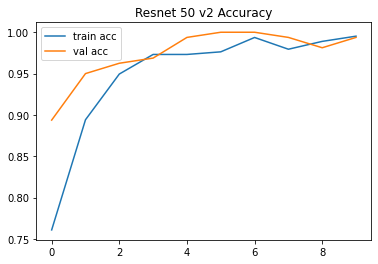

In [45]:
# accuracies
plt.plot(resnet_50_v2_history.history['acc'], label='train acc')
plt.plot(resnet_50_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 50 v2 Accuracy")
plt.legend()
plt.show()

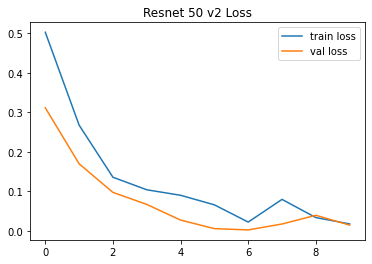

In [46]:
# loss
plt.plot(resnet_50_v2_history.history['loss'], label='train loss')
plt.plot(resnet_50_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 v2 Loss")
plt.legend()
plt.show()

In [47]:
#predict
y_pred=resnet_50_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

6/6 [==============================] - 1s 85ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.99      1.00      1.00       113

    accuracy                           0.99       163
   macro avg       1.00      0.99      0.99       163
weighted avg       0.99      0.99      0.99       163



In [48]:
#get confusion matrix
print(confusion_matrix(y_pred,y_test))

del resnet_50_v2_history
del y_pred

gc.collect()

[[ 49   1]
 [  0 113]]


8571

[95.70552110671997, 93.86503100395203, 99.38650131225586]


Text(0.5, 1.0, 'Accuracy score Comparison during (Higher is better)')

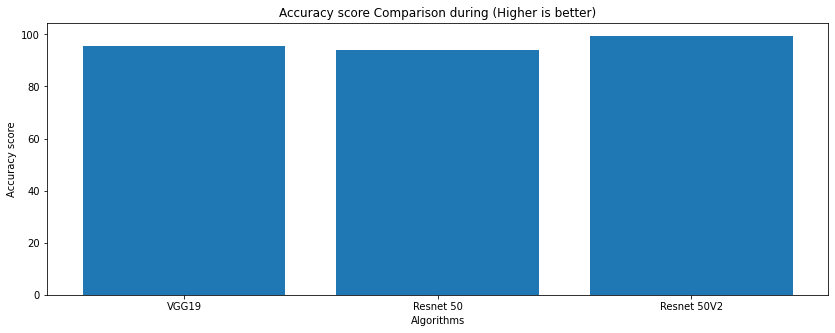

In [49]:
algorithms = ["VGG19","Resnet 50","Resnet 50V2"]
Accuracy = [vgg_acc*100,resnet_50_acc*100,resnet_50_v2_acc*100]
print(Accuracy)

plt.figure(figsize=[14,5])
plt.bar(algorithms, Accuracy)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")
plt.title("Accuracy score Comparison during (Higher is better)")

In [50]:
resnet_50_model.save("/content/drive/MyDrive/liver_tumor_resnet_50v2_model.h5", save_format="h5")